# DUI DNN
Deep Urban Interaction - Deep Neural Network  
Interaction Classification with OpenCV, OpenPose, and PyTorch  
Ryan Yan Zhang <ryanz@mit.edu>  
City Science, MIT Media Lab  

In [14]:
# General Imports
from pprint import pprint
import random
import datetime
import time

from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Image from video with OpenCV

In [2]:
import cv2
import os

# input parameters
videos_src_path = '../data/viz/01_input_videos'
images_save_path = '../data/viz/02_extracted_images'
intervel_second = 5.0 #0.5    # extraction intervel in seconds


#main code
if not os.path.exists(images_save_path):
    os.makedirs(images_save_path)
    print('made path: {}'.format(images_save_path))
# get file list
video_file_names = [f for f in os.listdir(videos_src_path) if os.path.isfile(os.path.join(videos_src_path, f)) and f.endswith('.mp4')]

for input_file_name in video_file_names:

    print('input_file_name = ' + input_file_name)
    vc = cv2.VideoCapture(os.path.join(videos_src_path, input_file_name))
    fps = int(round(vc.get(cv2.CAP_PROP_FPS)))
    intervel_frame = int(round(intervel_second * fps))
    total_frames = vc.get(cv2.CAP_PROP_FRAME_COUNT) # maybe inaccurate
    print('total_frames = ' + str(total_frames))

    if (vc.isOpened() == False): 
        print('Error opening video stream or file')
        exit()
    
    frame_get = 0
    time_second = 0

    while frame_get < total_frames:    # loop reading frames, set last frame
        rval, frame = vc.read()
        if rval == True:
            if frame_get % intervel_frame == 0:    # save image every intervel_frame
                time_second = int(frame_get/fps)    # int is floor
                image_file_name = '{}_{}.png'.format(os.path.splitext(input_file_name)[0], str(frame_get).zfill(5))
                cv2.imwrite(os.path.join(images_save_path, image_file_name), frame)    # save as image
                #cv2.waitKey(0)
                print('{} is saved'.format(image_file_name))
            frame_get += 1

    vc.release()

input_file_name = 180305_ML Test Video_v1.mp4
total_frames = 900.0
180305_ML Test Video_v1_00000.png is saved
180305_ML Test Video_v1_00150.png is saved
180305_ML Test Video_v1_00300.png is saved
180305_ML Test Video_v1_00450.png is saved
180305_ML Test Video_v1_00600.png is saved
180305_ML Test Video_v1_00750.png is saved


## Pose json from image with OpenPose

In [3]:
import subprocess
import time
import os
import sys

# input parameters
input_path = r'C:\Users\RYAN\Documents\GitHub\CS_Urban_Interaction_CV\interaction-analysis-python\02_interaction-classification\PyTorch_RZ\data\viz\02_extracted_images'
output_path = r'C:\Users\RYAN\Documents\GitHub\CS_Urban_Interaction_CV\interaction-analysis-python\02_interaction-classification\PyTorch_RZ\data\viz\03_openpose_jsons'
openpose_path = r'C:\OpenPose\openpose-1.2.1-win64-binaries'

# main code
if not os.path.exists(input_path):
    sys.exit('input path doesn\'t exist!')
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print('made path: {}'.format(output_path))

start = time.time()
cmd = r'cd {} && bin\OpenPoseDemo.exe --image_dir "{}" --write_json "{}" --no_display --render_pose 0'.format(openpose_path, input_path, output_path)
subprocess.check_output(cmd, shell=True)
print(f'openpose json time used: {(time.time() - start)}')

openpose json time used: 6.212425470352173


## People Bounding box from OpenPose

In [4]:
import cv2
import numpy as np
import json
from pprint import pprint
import os

# constant parameters
xx = 0
yy = 1

# input parameters
img_path = r'C:\Users\RYAN\Documents\GitHub\CS_Urban_Interaction_CV\interaction-analysis-python\02_interaction-classification\PyTorch_RZ\data\viz\02_extracted_images'
json_path = r'C:\Users\RYAN\Documents\GitHub\CS_Urban_Interaction_CV\interaction-analysis-python\02_interaction-classification\PyTorch_RZ\data\viz\03_openpose_jsons'
img_out_path = r'C:\Users\RYAN\Documents\GitHub\CS_Urban_Interaction_CV\interaction-analysis-python\02_interaction-classification\PyTorch_RZ\data\viz\04_bounding_box_images'
json_label_path = r'C:\Users\RYAN\Documents\GitHub\CS_Urban_Interaction_CV\interaction-analysis-python\02_interaction-classification\PyTorch_RZ\data\viz\05_bounding_box_jsons'
fps = 30
joint_confident_threshold = 0.1
d_expand_fixed = 50.0

# get file list. Make sure that the image names' order is corespondent to the json file names' order!!!
img_file_names = [f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))]
json_file_names = [f for f in os.listdir(json_path) if os.path.isfile(os.path.join(json_path, f))]


# loop all the image files, json files, and save result
for input_image_file_name in os.listdir(img_path):
    if (input_image_file_name.endswith(".png") or input_image_file_name.endswith(".jpg")):
        #print(os.path.join(img_path, input_image_file_name))
        input_json_file_name = os.path.splitext(input_image_file_name)[0] + "_keypoints.json"
        #print(os.path.join(json_path, input_json_file_name))
        output_image_file_name = os.path.splitext(input_image_file_name)[0] + "_tagged.png"
        #print(os.path.join(img_out_path, output_image_file_name))
        json_label_file_name = input_image_file_name + ".json"
        
        # Load an color image
        img = cv2.imread(os.path.join(img_path, input_image_file_name))
        # read the json file
        with open(os.path.join(json_path, input_json_file_name)) as f:
            json_data = json.load(f)
        
        # get data of effective joints of people in one json file
        joint_confident_threshold = 0.1
        # loop person in one json
        people_list = []
        for i in range(len(json_data["people"])):
            # loop joints of one person
            effective_joint_xy_list = []
            for j in range(int(len(json_data["people"][i]["pose_keypoints"])/3)):
                if json_data["people"][i]["pose_keypoints"][j*3+2] > joint_confident_threshold:
                    effective_joint_xy_list.append([json_data["people"][i]["pose_keypoints"][j*3+xx], json_data["people"][i]["pose_keypoints"][j*3+yy]])
            people_list.append(effective_joint_xy_list)
        
        # analysis to extrapolate the bounding box
        # simple max min bounding box of all the joints plus expand distance joint 0 to joint 1 for all 4 side
        # loop person
        box_list = []
        for i in range(len(people_list)):
            box = [[9999999,9999999],[0,0]] #[upper_left_xy,lower_right_xy]
            joint_list = people_list[i]
            d_expand = d_expand_fixed

            # loop joint xy
            for j in range(len(joint_list)):
                joint_xy = joint_list[j]
                box = [[min(box[0][xx],joint_xy[xx]),min(box[0][yy],joint_xy[yy])],[max(box[1][xx],joint_xy[xx]),max(box[1][yy],joint_xy[yy])]]
            # expend the box by distance joint 0 to joint 1 for all 4 side
            box = [[box[0][xx]-d_expand,box[0][yy]-d_expand],[box[1][xx]+d_expand,box[1][yy]+d_expand]]
            box_list.append(box)
        
        # draw the boxes
        for i in range(len(box_list)):
            box = box_list[i]
            cv2.rectangle(img,(int(box[0][xx]),int(box[0][yy])),(int(box[1][xx]),int(box[1][yy])),(255,255,255),2)
        
        # write the image in to file
        cv2.imwrite(os.path.join(img_out_path, output_image_file_name), img)
        print('{} is saved'.format(output_image_file_name))
        
        # construct json_label
        data = {}
        data['filename'] = input_image_file_name
        data['file_ext'] = os.path.splitext(input_image_file_name)[1]
        data['file_path'] = img_path
        height, width, channels = img.shape
        data['file_dim'] = [width, height]
        data['people'] = []
        for i in range(len(box_list)):
            box = box_list[i]
            pplData = {}
            pplData['tl_coord'] = [int(box[0][xx]),int(box[1][yy])]
            pplData['br_coord'] = [int(box[1][xx]),int(box[0][yy])]
            pplData['dims'] = [int(box[1][xx]-box[0][xx]), int(box[1][yy]-box[0][yy])]
            pplData['area'] = int(box[1][xx]-box[0][xx]) * int(box[1][yy]-box[0][yy])
            data['people'].append(pplData)
        data['count'] = len(box_list)
        
        with open(os.path.join(json_label_path, json_label_file_name), 'w') as outfile:
            json.dump(data, outfile, indent=4)
        
        #t = t + 1  # run only first t-1 files
        continue
    else:
        #t = t + 1  # run only first t-1 files
        continue

180305_ML Test Video_v1_00000_tagged.png is saved
180305_ML Test Video_v1_00150_tagged.png is saved
180305_ML Test Video_v1_00300_tagged.png is saved
180305_ML Test Video_v1_00450_tagged.png is saved
180305_ML Test Video_v1_00600_tagged.png is saved
180305_ML Test Video_v1_00750_tagged.png is saved


## Interaction Classification with PyTorch DNN

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets.folder import ImageFolder, default_loader
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda:0


In [6]:
# Training helpers
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)


def get_frozen(model_params):
    return (p for p in model_params if not p.requires_grad)


def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)


def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)


def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

In [7]:
# Data augmentation transforms

from torchvision import transforms

IMG_SIZE = 224  #224  #defined by NN model input
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]


train_trans = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),  #256  #(IMG_SIZE, IMG_SIZE)  # some images are pretty small
    #transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])
val_trans = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),  #256  #(IMG_SIZE, IMG_SIZE)
    #transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])

In [8]:
# Data set
train_ds = ImageFolder("../data/raw/DUI/train", transform=train_trans, loader=default_loader)
val_ds = ImageFolder("../data/raw/DUI/valid", transform=train_trans, loader=default_loader)
#print(f'len(train_ds): {len(train_ds)}, len(val_ds): {len(val_ds)}')

BATCH_SIZE = 128  #2  #256  #512  #32  #220 for resnet152 on Dell Presison 5520 laptop, 400 for resnet18

n_classes = 2

# DataLoader
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
)

In [9]:
# Model
model = models.resnet18(pretrained=True)
#model = models.resnet50(pretrained=True)
#model = models.resnet101(pretrained=True)
#model = models.resnet152(pretrained=True)

# Transfer learning or whole model training
# Opt.1 Transfer learning
'''
# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False
#print(fall_frozen(model.parameters()): {all_frozen(model.parameters())}')

model.fc = nn.Linear(512, n_classes)  # according to the model, 512 for resnet18, 2048 for resnet50 & resnet101 & resnet152

model = model.to(device)
'''

# Opt.2 Whole model training
for param in model.parameters():
    param.requires_grad = True

In [10]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(
    get_trainable(model.parameters()),
    # model.fc.parameters(),
    lr=0.001,
    # momentum=0.9,
)

In [11]:
# Train loop
if False:
    N_EPOCHS = 10  #1  #2  #10
    for epoch in range(N_EPOCHS):

        # start epoch
        start_time = time.time()
        start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"Epoch {epoch+1}/{N_EPOCHS}")
        print(f'  Start Time: {start_datetime}')

        # Train
        model.train()  # IMPORTANT

        running_loss, correct = 0.0, 0
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            # with torch.set_grad_enabled(True):
            y_ = model(X)
            loss = criterion(y_, y)

            loss.backward()
            optimizer.step()

            # Statistics
            print(f"    batch loss: {loss.item():0.3f}")
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            running_loss += loss.item() * X.shape[0]

        print(f"  Train Loss: {running_loss / len(train_dl.dataset)}")
        print(f"  Train Acc:  {correct / len(train_dl.dataset)}")


        # Eval
        model.eval()  # IMPORTANT

        running_loss, correct = 0.0, 0
        with torch.no_grad():  # IMPORTANT
            for X, y in val_dl:
                X, y = X.to(device), y.to(device)

                y_ = model(X)

                _, y_label_ = torch.max(y_, 1)
                correct += (y_label_ == y).sum().item()

                loss = criterion(y_, y)
                running_loss += loss.item() * X.shape[0]

        print(f"  Valid Loss: {running_loss / len(val_dl.dataset)}")
        print(f"  Valid Acc:  {correct / len(val_dl.dataset)}")

        # end epoch
        end_time = time.time()
        end_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        time_elapsed = end_time - start_time
        datetime_elapsed = str(datetime.timedelta(seconds = time_elapsed))
        print(f'  End Time: {end_datetime}')
        print(f'  Time Elapsed: {datetime_elapsed}')
        print()

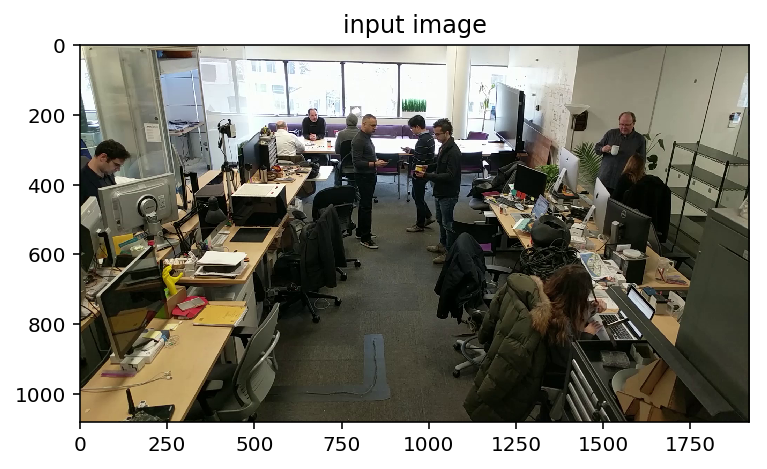

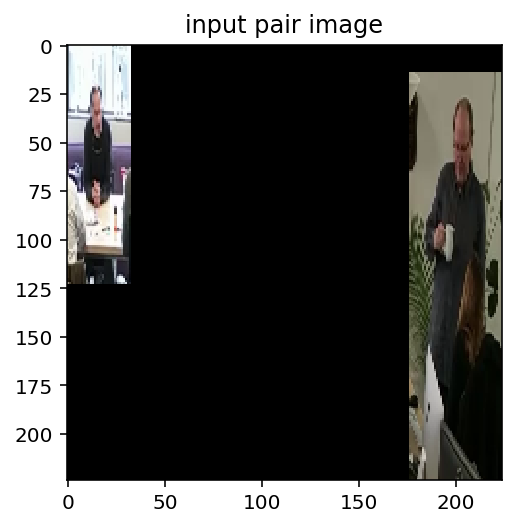

y_label_: 		tensor([1], device='cuda:0')


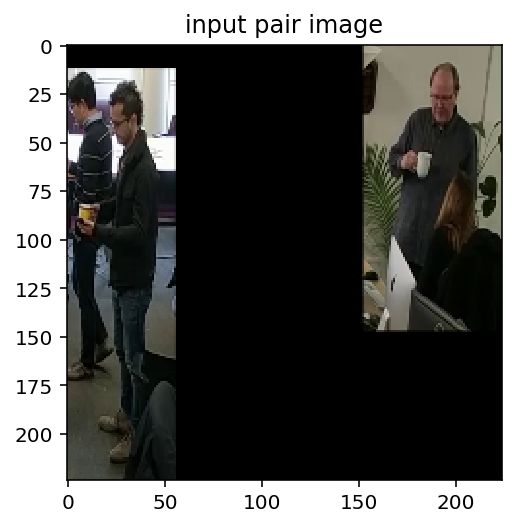

y_label_: 		tensor([1], device='cuda:0')


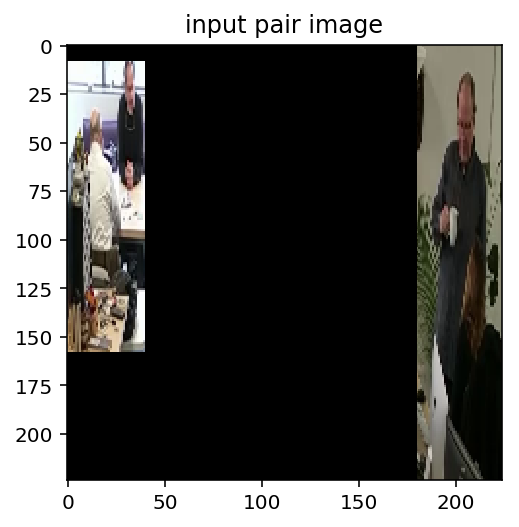

y_label_: 		tensor([1], device='cuda:0')


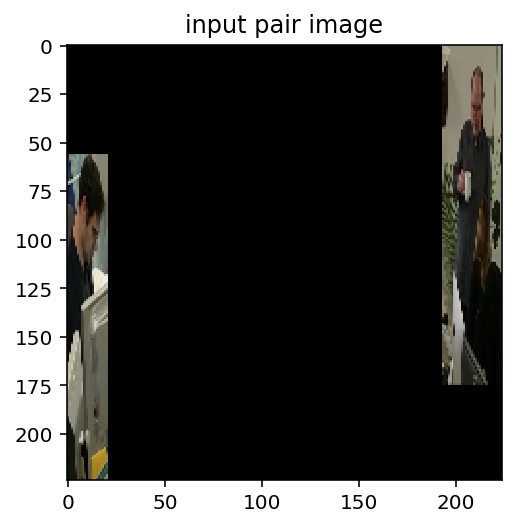

y_label_: 		tensor([0], device='cuda:0')


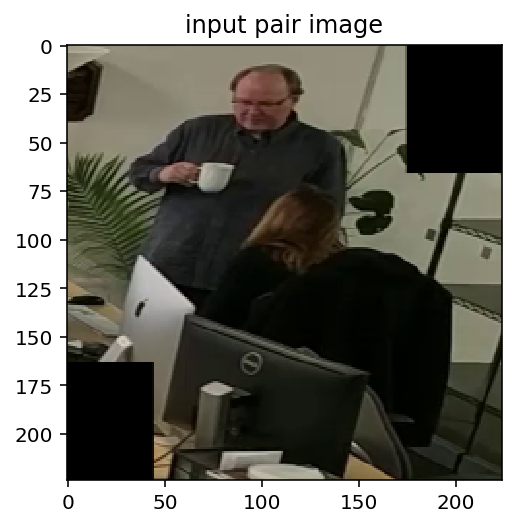

y_label_: 		tensor([0], device='cuda:0')


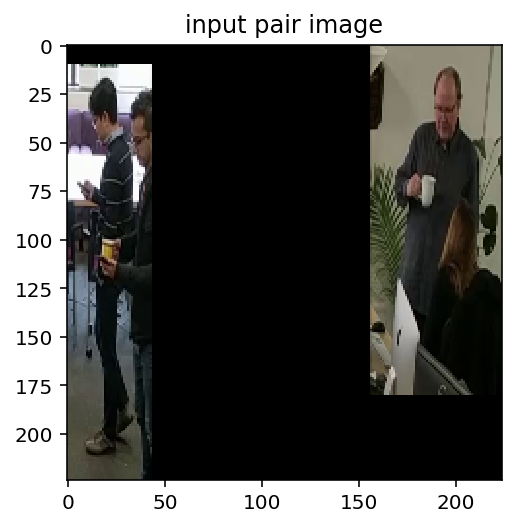

y_label_: 		tensor([1], device='cuda:0')


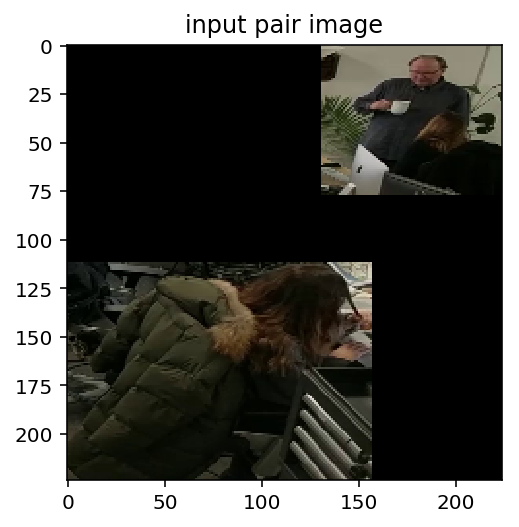

y_label_: 		tensor([1], device='cuda:0')


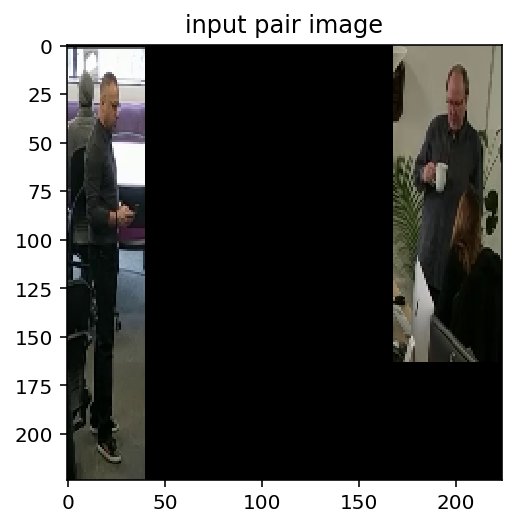

y_label_: 		tensor([1], device='cuda:0')


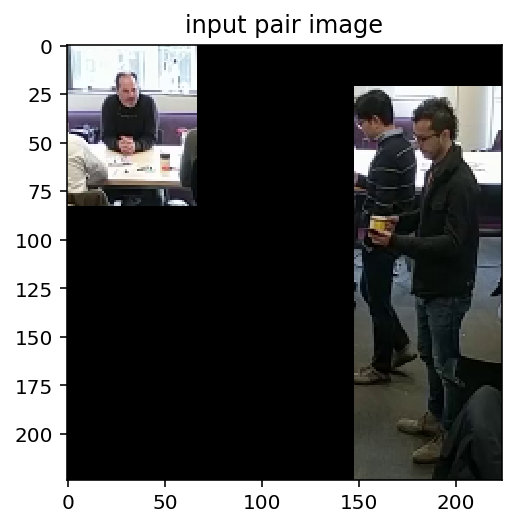

y_label_: 		tensor([1], device='cuda:0')


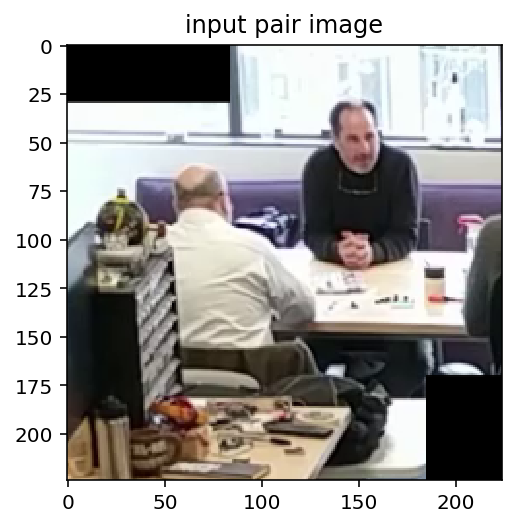

y_label_: 		tensor([1], device='cuda:0')


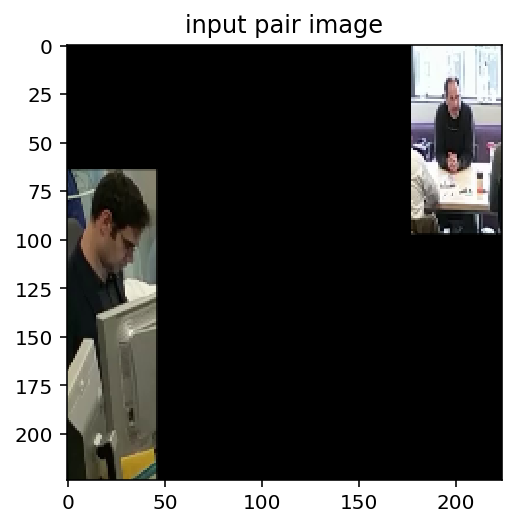

y_label_: 		tensor([1], device='cuda:0')


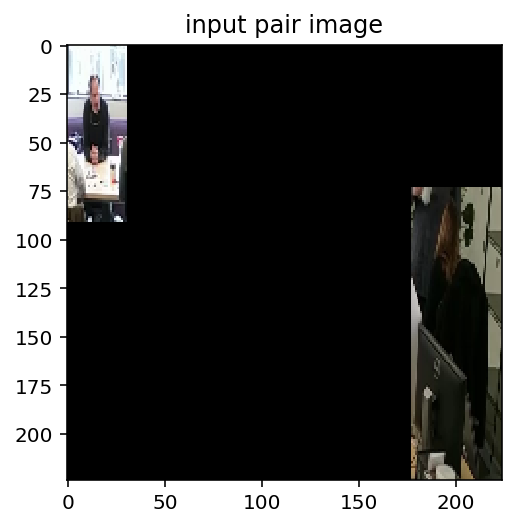

y_label_: 		tensor([1], device='cuda:0')


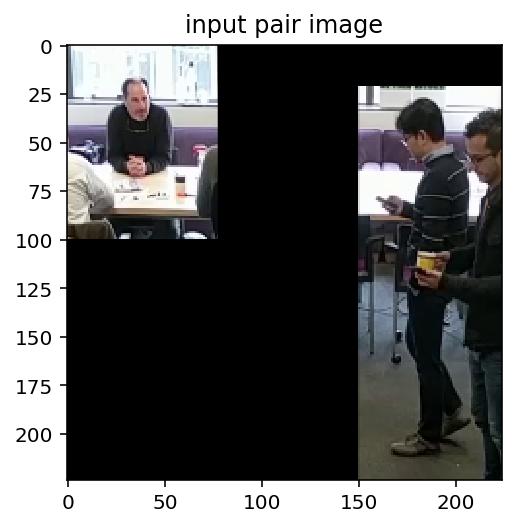

y_label_: 		tensor([1], device='cuda:0')


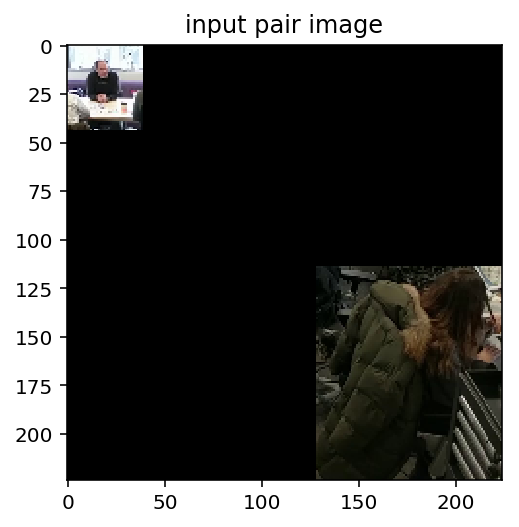

y_label_: 		tensor([0], device='cuda:0')


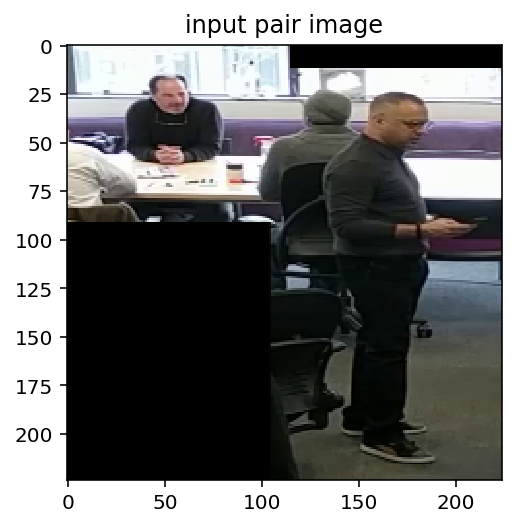

y_label_: 		tensor([1], device='cuda:0')


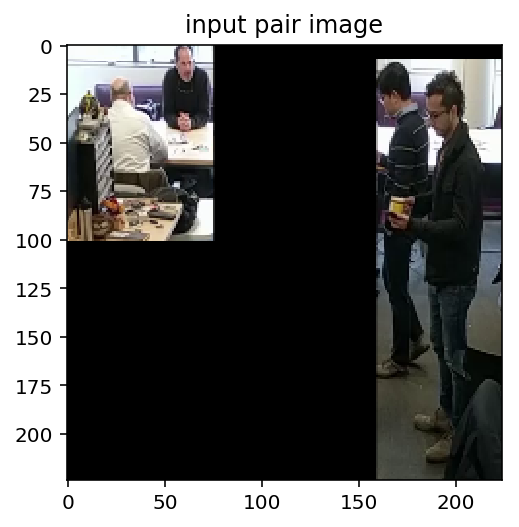

y_label_: 		tensor([1], device='cuda:0')


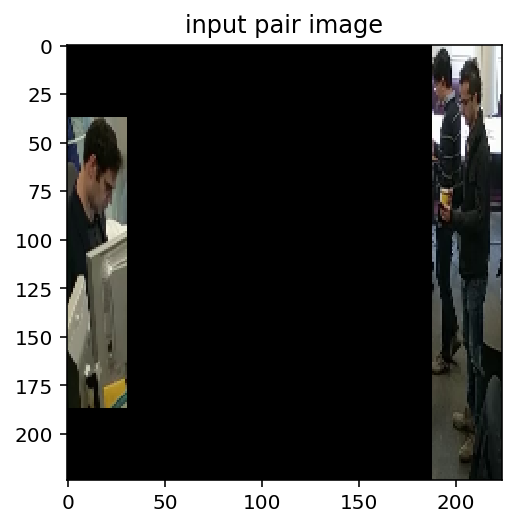

y_label_: 		tensor([1], device='cuda:0')


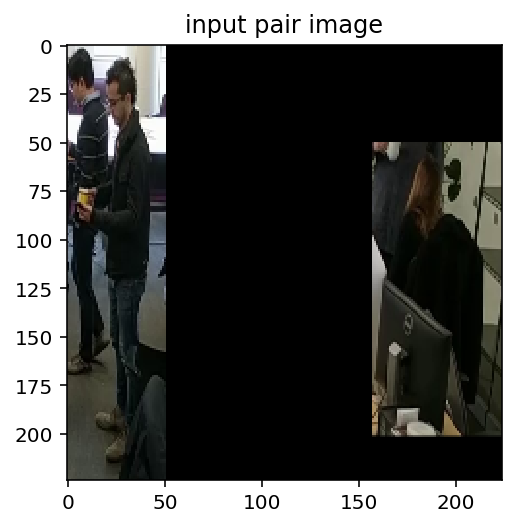

y_label_: 		tensor([0], device='cuda:0')


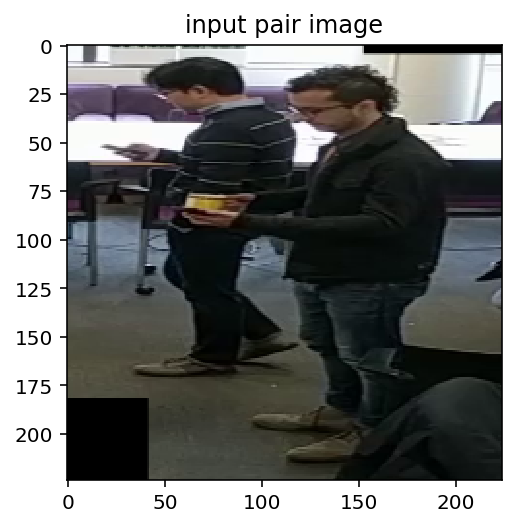

y_label_: 		tensor([0], device='cuda:0')


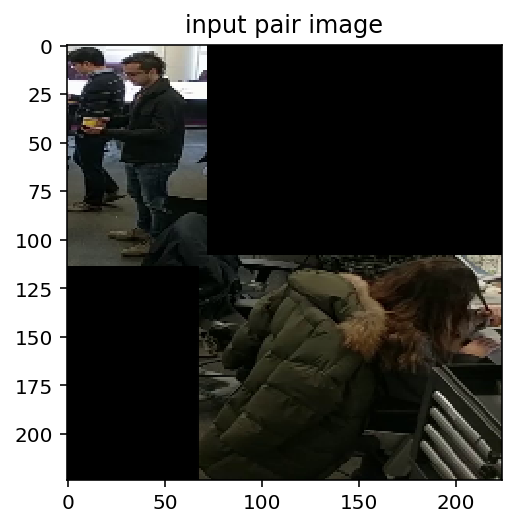

y_label_: 		tensor([0], device='cuda:0')


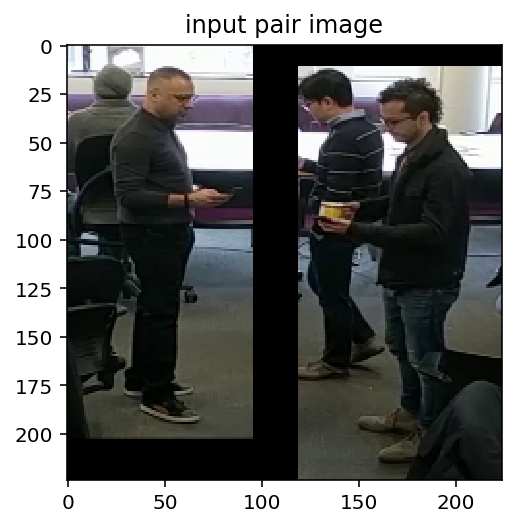

y_label_: 		tensor([1], device='cuda:0')


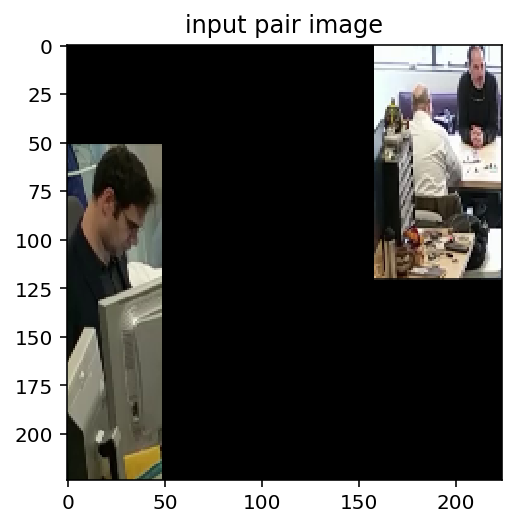

y_label_: 		tensor([1], device='cuda:0')


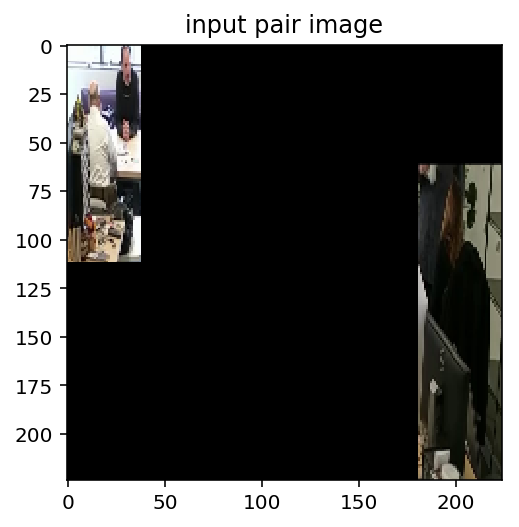

y_label_: 		tensor([0], device='cuda:0')


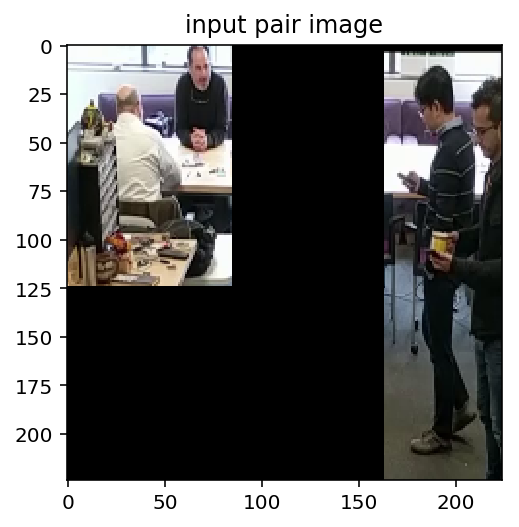

y_label_: 		tensor([1], device='cuda:0')


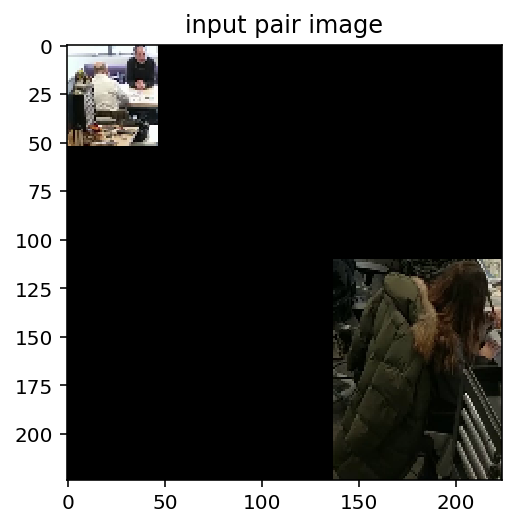

y_label_: 		tensor([1], device='cuda:0')


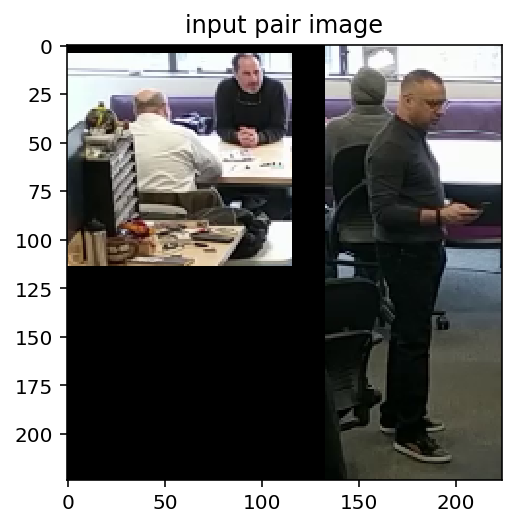

y_label_: 		tensor([0], device='cuda:0')


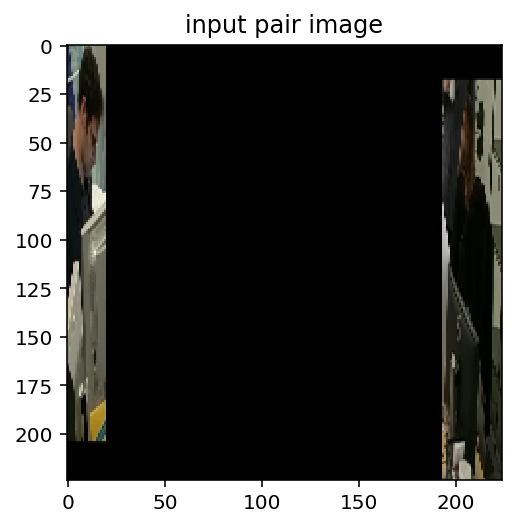

y_label_: 		tensor([1], device='cuda:0')


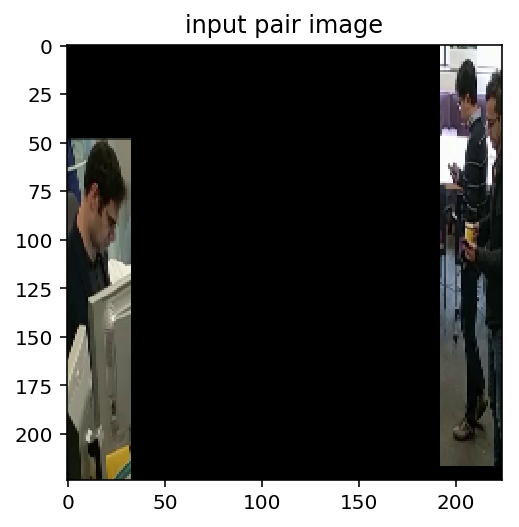

y_label_: 		tensor([1], device='cuda:0')


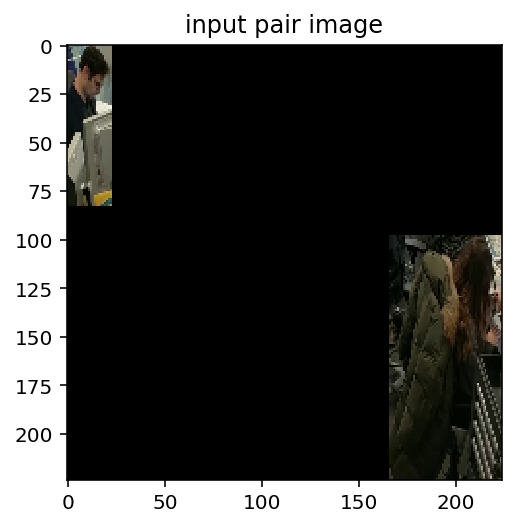

y_label_: 		tensor([0], device='cuda:0')


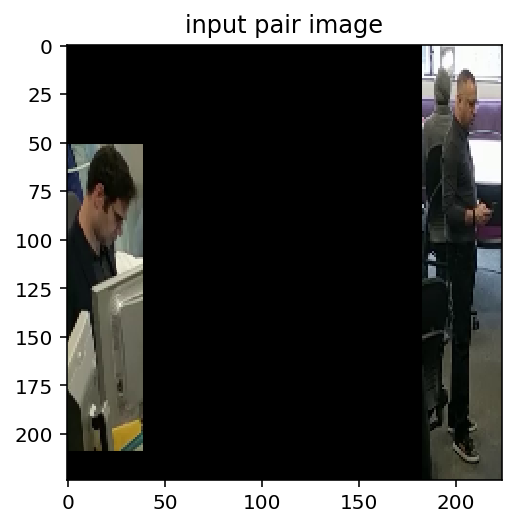

y_label_: 		tensor([1], device='cuda:0')


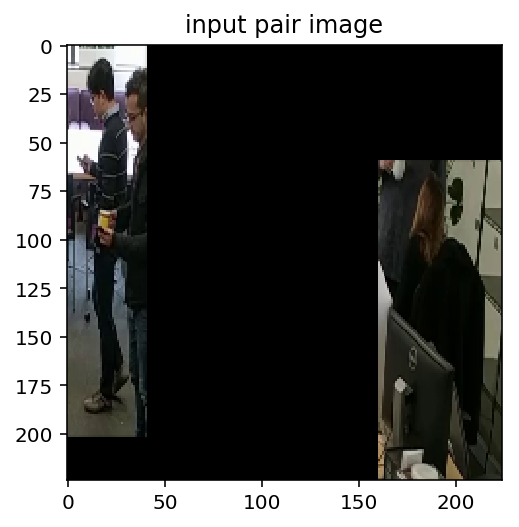

y_label_: 		tensor([1], device='cuda:0')


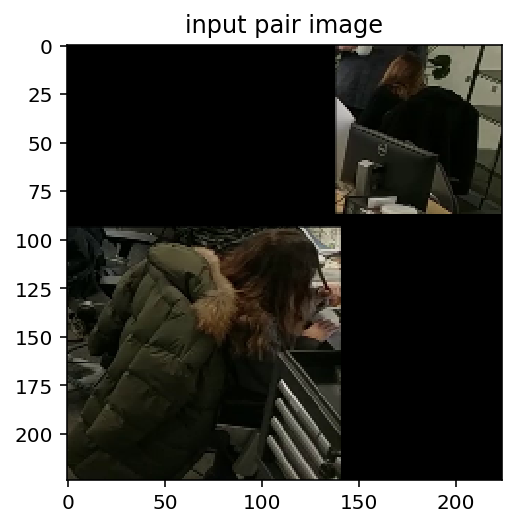

y_label_: 		tensor([0], device='cuda:0')


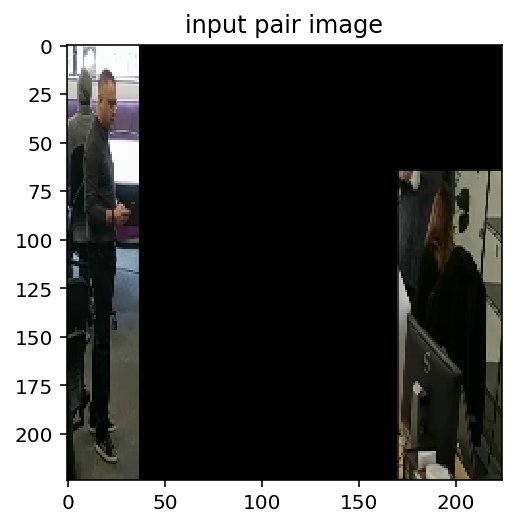

y_label_: 		tensor([0], device='cuda:0')


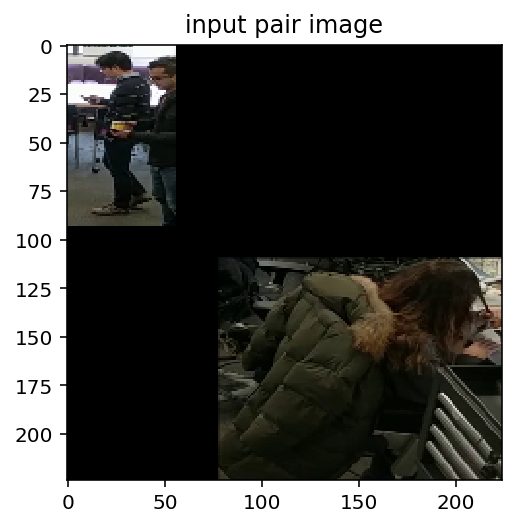

y_label_: 		tensor([0], device='cuda:0')


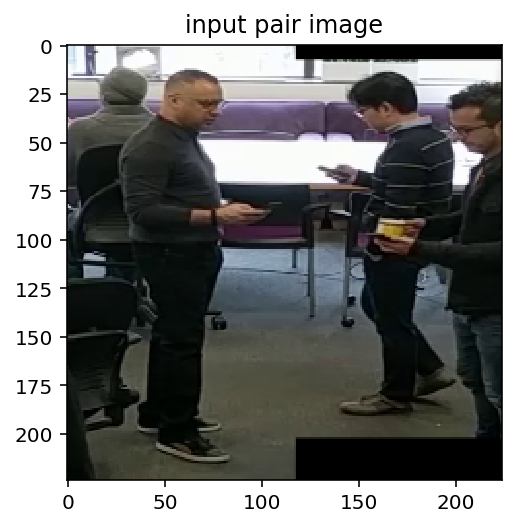

y_label_: 		tensor([0], device='cuda:0')


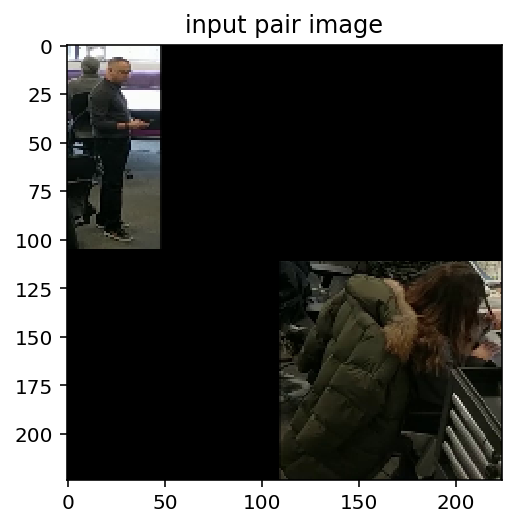

y_label_: 		tensor([0], device='cuda:0')


In [37]:
# Predict with Trained Model


# save the trained model weights
model_weights_path = '../data/saved_model_weights/resnet18_whole'

# save a trained model weights
if False:
    torch.save(model.state_dict(), model_weights_path)

# load the trained model weights
if True:
    from torchvision import models
    model = models.resnet18(pretrained=True)  # resnet50, 101, 152
    model.load_state_dict(torch.load(model_weights_path))
    model = model.to(device)


# load test data set
test_ds = ImageFolder("../data/raw/DUI/test", transform=val_trans, loader=default_loader)
#print(f'len(test_ds) = {len(test_ds)}. ')

test_dl = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

#print(f'test_ds[99]: \n{test_ds[99]}')
#print(f'test_ds[99][1]: \n{test_ds[99][1]}')

'''
# predict
model.eval()  # IMPORTANT
with torch.no_grad():  # IMPORTANT
    for X, y in test_dl:
        X, y = X.to(device), y.to(device)
        print(f'X: {X}')
        print(f'X.shape: {X.shape}')
        #print(f'y: \t\t\t{y}')

        y_ = model(X)
        _, y_label_ = torch.max(y_, 1)
        #print(f'y_label_: \t\t{y_label_}')
        
        is_correct = 'correct' if y_label_ == y else 'wrong'
        #print(f'is_correct: \t{is_correct}\n')'''

# get people bounding box json list


# loop images and people bounding box jsons
#for json in jsons:
    

# load 1 image and 1 people bounding box json
json_path = r'C:\Users\RYAN\Documents\GitHub\CS_Urban_Interaction_CV\interaction-analysis-python\02_interaction-classification\PyTorch_RZ\data\viz\05_bounding_box_jsons\180305_ML Test Video_v1_00000.png.json'

# load 1 json data
with open(json_path) as f:
    json_data = json.load(f)

# load 1 image
image_path = os.path.join(json_data['file_path'], json_data['filename'])
img_BGR = cv2.imread(image_path)
height, width, channels = img_BGR.shape
#img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_gray)
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
plt.imshow(img_RGB)
plt.title('input image')
plt.show()

# get pairs in 1 image
crop_to_ext = True
pair_imgs = []
# count largar than 1
if json_data['count'] > 1:
    num_ppl = len(json_data['people'])
    for j in range(num_ppl):
        for i in range(num_ppl):
            if i > j:
                person_0 = json_data['people'][j]
                person_1 = json_data['people'][i]
                # create a black image
                new_img_RGB = np.zeros((height,width,3), np.uint8)
                # copy pixels of the regions of two persons
                # person_0
                y0 = min(person_0['tl_coord'][yy], person_0['br_coord'][yy])
                y1 = max(person_0['tl_coord'][yy], person_0['br_coord'][yy])
                x0 = min(person_0['tl_coord'][xx], person_0['br_coord'][xx])
                x1 = max(person_0['tl_coord'][xx], person_0['br_coord'][xx])
                if x0 < 0: x0 = 0
                if y0 < 0: y0 = 0
                new_img_RGB[y0:y1, x0:x1] = img_RGB[y0:y1, x0:x1]
                # person_1
                y2 = min(person_1['tl_coord'][yy], person_1['br_coord'][yy])
                y3 = max(person_1['tl_coord'][yy], person_1['br_coord'][yy])
                x2 = min(person_1['tl_coord'][xx], person_1['br_coord'][xx])
                x3 = max(person_1['tl_coord'][xx], person_1['br_coord'][xx])
                if x2 < 0: x2 = 0
                if y2 < 0: y2 = 0
                new_img_RGB[y2:y3, x2:x3] = img_RGB[y2:y3, x2:x3]
                # if crop_to_ext
                if crop_to_ext:
                    x4 = min(x0, x2)
                    x5 = max(x1, x3)
                    y4 = min(y0, y2)
                    y5 = max(y1, y3)
                    new_img_RGB = new_img_RGB[y4:y5, x4:x5]
                pair_imgs.append(new_img_RGB)

# predict
model.eval()  # IMPORTANT
with torch.no_grad():  # IMPORTANT
    # loop pairs
    for pair_img in pair_imgs:
        # transforms - resize, normalize, toTensor
        pair_img = cv2.resize(pair_img,(IMG_SIZE, IMG_SIZE))
        plt.imshow(pair_img)
        plt.title('input pair image')
        plt.show()
        pair_img = (pair_img - _mean) / _std
        pair_img = pair_img.transpose((2, 0, 1))
        X = torch.from_numpy(pair_img)
        X = X.unsqueeze(0)
        X = X.type(torch.FloatTensor)
        X = X.to(device)
        #print(f'X: {X}')
        #print(f'X.shape: {X.shape}')

        y_ = model(X)
        _, y_label_ = torch.max(y_, 1)
        print(f'y_label_: \t\t{y_label_}')
pass